In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
import time

<font size="5">**Question 1**

In [2]:
df = pd.read_csv(r'DailyReturn.csv')
df = df.iloc[: , 1:]

In [3]:
def ewm (x, exp_w, lamda):
    w = []
    sum_w = 0
    n = x.shape[1]
    for i in range(1, len(x.index)+1):
        w.append((1-lamda)*lamda**(i-1))
        sum_w = sum_w + w[i-1]
    for i in range(len(x.index)):   
        exp_w.append(w[i] / sum_w)
    
    
    cov_matrix = np.zeros([n,n])
    for i in range (len(x.index)):
        for j in range (n):
            x.iloc[i,j] = x.iloc[i,j] - np.mean(x.iloc[:,j])
    
            
    for i in range (n):
        for j in range (n):
            temp = exp_w * x.iloc[:,i]
            cov_matrix[i,j] = np.dot(temp, x.iloc[:, j])
            
    return cov_matrix

In [4]:
def getCumm_var(x, lamb):
    exp_w = []
    cov_matrix = ewm(x, exp_w, lamb)
    v1, w1 = LA.eigh(cov_matrix)
    
    tot = 0
    for i in range(len(v1)):
        tot += v1[i]
    v1 = v1[::-1]
    
    cumu_var = []
    k=1
    for i in range(len(v1)):
        sum_v = 0
        for j in range(k):
            sum_v += v1[j]
        cumu_var.append(sum_v / tot)
        k = k + 1
    return cumu_var

In [5]:
cumu_1 = getCumm_var(df, 0.97)
cumu_2 = getCumm_var(df, 0.9)
cumu_3 = getCumm_var(df, 0.8)
cumu_4 = getCumm_var(df, 0.7)
cumu_5 = getCumm_var(df, 0.6)

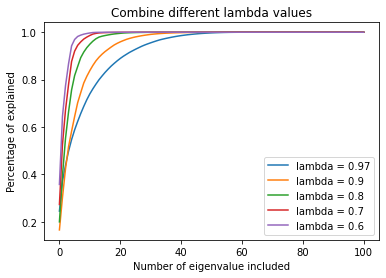

In [6]:
fig, ax = plt.subplots()
ax.set_title("Combine different lambda values")
ax.set_xlabel('Number of eigenvalue included')
ax.set_ylabel('Percentage of explained')

ax.plot(cumu_1, label = 'lambda = 0.97')
ax.plot(cumu_2, label = 'lambda = 0.9')
ax.plot(cumu_3, label = 'lambda = 0.8')
ax.plot(cumu_4, label = 'lambda = 0.7')
ax.plot(cumu_5, label = 'lambda = 0.6')

ax.legend()

<font size="3">The more weight on the old data, the less number of eigenvalue needed to explain the data set.

<font size="5">**Question 2**

In [7]:
n = 500
sigma = np.full((n,n), 0.9)
for i in range(n):
    sigma[i,i] = 1.0
sigma[1,2] = 0.7357
sigma[2,1] = 0.7357

In [8]:
def is_psd(x):
    return np.all(LA.eigvals(x) >= -1e-8)

In [9]:
def chol_psd(root, a):
    n = a.shape[0]
    
    for j in range(n):
        s = 0.0
        if j>0:
            s = root[j, :j] @ root[j, :j].T
            
        temp = a[j, j] - s
        
        if -1e-8 <= temp <= 0:
            temp = 0.0
        
        root[j,j] = np.sqrt(temp);
        
        if root[j,j] == 0.0:
            continue
            
        ir = 1.0/root[j,j]
            
        for i in range(j+1, n):
                s = root[i, :j] @ root[j, :j].T
                root[i,j] = (a[i,j] - s) * ir
    return root

In [10]:
def nearPSD(A, epsilon=0):
    n = A.shape[0]
    invSD = None
    out = A.copy()
    A_diag = np.diag(A)
    
    #convert cov to cor matrix
    if (np.count_nonzero(A_diag == 1) != n):
        invSD = np.diag(np.divide(1, np.sqrt(A_diag)))
        out = invSD * out * invSD
    
    eigval, eigvec = LA.eigh(out)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    
    T = 1/(np.multiply(vec,vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)))))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    out = B * B.T
    
    if invSD != None:
        invSD_diag = np.diag(invSD)
        invSD = np.diag(np.divide(1, np.sqrt(invSD_diag)))
        out = invSD * out * invSD
    
    return out

In [11]:
#Higham2002
def _getAplus(A):
    eigval, eigvec = LA.eigh(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return eigvec @ xdiag @ eigvec.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    iW = W05.I
    return  iW @ _getAplus(W05 @ A @ W05) @ iW

def _getPu(A, W=None):
    Aret = A.copy()
    for i in range(0, A.shape[0]):
        Aret[i,i] = 1
    return Aret

def _wgtNorm(A, W = None):
    W05 = np.sqrt(W)
    W05 = W05 @ A @ W05
    return (W05 * W05).sum()

def hig_nearPSD(pc, W = None, epsilon = 1e-9, maxIter = 100, tol = 1e-9):
    n = pc.shape[0]
    if W == None:
        W = np.identity(n)
        
    deltaS = np.zeros((n,n))
    
    Yk = pc.copy()
    norml = 9999999
    i = 1
    
    while i <= maxIter:
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W)
        norm = _wgtNorm(Yk - pc, W)
        
        w, v = LA.eigh(Yk)
        minEigVal = np.min(w)
        
        if ((norm - norml) < tol) and (minEigVal > -epsilon):
            break
            
        norml = norm
        i = i + 1
        
    if i < maxIter:
        print("Converged in %d iterations.\n" % i)
    else:
        print("Converged failed after %d iterations.\n" % (i-1))
        
    return Yk

In [12]:
def F_norm (cov, cov_psd):
    temp = cov - cov_psd
    return LA.norm(temp, 'fro')

In [13]:
start1 = time.time()

out_near = nearPSD(sigma)
is_psd(out_near)

end1 = time.time()

In [14]:
start2 = time.time()

out_hig = hig_nearPSD(sigma)
is_psd(out_hig)

end2 = time.time()

Converged in 26 iterations.



In [15]:
name = ['nearPSD', 'Higham2002']

norm = []
norm.append(F_norm(sigma, out_near))
norm.append(F_norm(sigma, out_hig))

runtime = []
runtime.append(end1-start1)
runtime.append(end2-start2)

result = pd.DataFrame(list(zip(name,norm,runtime)), columns = ['Name','Norm', 'RunTime'])
result

,Name,Norm,RunTime
0,nearPSD,0.627523,0.064820
1,Higham2002,0.089648,2.962368


<font size="5">**Question 3**

In [16]:
def getCor(cov):
    cov_diag = np.diag(cov)
    invSD = np.diag(np.divide(1, np.sqrt(cov_diag)))
    cor = invSD * cov * invSD
    return cor

def getCov(var, cor):
    std = np.sqrt(var)
    n = len(var)
    cov = np.matrix(np.zeros((n,n)))
    for i in range(n):
        for j in range(n):
            cov[i,j] = cor[i,j] * std[i] * std[j]
            
    return cov

In [17]:
pear_cov = np.matrix(df.cov())
pear_var = df.var()
pear_cor = np.matrix(df.corr())

In [18]:
ewm_cov = np.matrix(ewm(df, [], 0.97))
ewm_var = np.diag(ewm_cov)
ewm_cor = getCor(ewm_cov)

In [19]:
pear_var_cor = getCov(pear_var, pear_cor)
pear_var_ewm_cor = getCov(pear_var, ewm_cor)
ewm_var_pear_cor = getCov(ewm_var, pear_cor)
ewm_var_cor = getCov(ewm_var, ewm_cor)

In [20]:
def normal_sim(cov, nsim):
    if(cov.shape[0] != len(cov)):
        raise exception("covariance matrix is not square")
        
    n = cov.shape[0]
    root = np.zeros(cov.shape)    
    root = chol_psd(root, cov)
    np.random.seed(1234)
    z = np.random.normal(size=(n, nsim))
    return root @ z

In [21]:
def pca_sim(cov, nsim, target):
    val, vec = LA.eigh(cov)
    
    tot = sum(val)
    val = val[::-1]
    vec = vec[::-1]
    
    val = np.maximum(val, 0)
    
    cumm_val_explained = np.cumsum(val) / tot
    i=0
    for i in range(len(val)):
        if cumm_val_explained[i] < target:
            i += 1
        else:
            break
            
    val = val[0:i+1]
    vec = vec[:, :i+1]
    
    B = vec @ np.diag(np.sqrt(val))
    np.random.seed(1234)
    z = np.random.normal(size=(len(val), nsim))
    return B @ z

In [22]:
# Print Function
matrixType = ["PEARSON", "EWMA_COR_PEARSON_STD", "EWMA", "PEARSON_COR_EWMA_STD"]
simType = ["Full", "PCA=1", "PCA=0.75", "PCA=0.5"]

matrix = []
simulation = []
runtimes = []
norms = []

nsim = 25000
for sim in simType:
    for mat in matrixType:
        matrix.append(mat)
        simulation.append(sim)
        elapse = 0
        
        if mat == "PEARSON":
            c = pear_var_cor
        elif mat == "EWMA_COR_PEARSON_STD":
            c = pear_var_ewm_cor
        elif mat == "EWMA":
            c = ewm_var_cor 
        elif mat == "PEARSON_COR_EWMA_STD":
            c = ewm_var_pear_cor
            
        if sim == 'Full':
            start = time.time()
            s = normal_sim(c, nsim)
            end = time.time()
            elapse = end - start
        elif sim == 'PCA=1':
            start = time.time()
            s = pca_sim(c, nsim, 1)    
            end = time.time()
            elapse = end - start
        elif sim == 'PCA=0.75':
            start = time.time()
            s = pca_sim(c, nsim, 0.75)    
            end = time.time()
            elapse = end - start
        elif sim == 'PCA=0.5':
            start = time.time()
            s = pca_sim(c, nsim, 0.5)    
            end = time.time()
            elapse = end - start
        
        
        covar = np.cov(s)
        runtimes.append(elapse)
        norms.append(F_norm(covar, c))
              

In [23]:
result = pd.DataFrame(list(zip(matrix, simulation, norms, runtimes,)), columns = ['Name','Simulation', 'Norm', 'RunTime'])
result

,Name,Simulation,Norm,RunTime
0,PEARSON,Full,0.000238,0.088036
1,EWMA_COR_PEARSON_STD,Full,0.000232,0.097021
2,EWMA,Full,0.000226,0.094039
3,PEARSON_COR_EWMA_STD,Full,0.000231,0.089018
4,PEARSON,PCA=1,0.016320,0.054011
5,EWMA_COR_PEARSON_STD,PCA=1,0.014987,0.051011
6,EWMA,PCA=1,0.014093,0.089021
7,PEARSON_COR_EWMA_STD,PCA=1,0.015262,0.090559
8,PEARSON,PCA=0.75,0.016378,0.016020
9,EWMA_COR_PEARSON_STD,PCA=0.75,0.015047,0.020003
